# Single and Bi-Tensor models

In [28]:
import os
import os.path
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import nibabel as nib

In [2]:
base_filename = "../data/output/S264294/S264294_DTI_gated_20150508093306_12"

In [3]:
fdwi = base_filename + "crop.nii.gz"
fbval = base_filename + ".bval"
fbvec = base_filename + ".bvec"

In [4]:
img = nib.load(fdwi)
data = img.get_data()

In [5]:
data.shape

(40, 45, 12, 65)

In [6]:
print(img.header.get_zooms()[:3])

(1.9827586, 1.9827586, 2.0)


In [7]:
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

In [8]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [9]:
gtab.info

B-values shape (65,)
         min 0.000000 
         max 1000.000000 
B-vectors shape (65, 3)
         min -0.964118 
         max 0.999988 


In [10]:
# b values for single shell
print(gtab.bvals)

[   0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000.]


In [11]:
# First few gradient directions
print(gtab.bvecs[:10, :])

[[ 0.          0.          0.        ]
 [ 0.999975   -0.00504502 -0.00503994]
 [ 0.          0.999988   -0.00497989]
 [-0.0249489   0.65464    -0.755529  ]
 [ 0.589353   -0.769866   -0.244886  ]
 [-0.235876   -0.529835   -0.81464   ]
 [-0.893575   -0.264756   -0.36253   ]
 [ 0.797989    0.133987   -0.58759   ]
 [ 0.232856    0.932211   -0.277056  ]
 [ 0.936737    0.145261   -0.31847   ]]


In [12]:
S0s = data[:, :, :, gtab.b0s_mask]
S0s.shape

(40, 45, 12, 1)

In [13]:
data.dtype

dtype('<i2')

In [14]:
S0s[:,:,10, 0].max()

1434

In [15]:
S0s[:,:,:, 0].min()

10

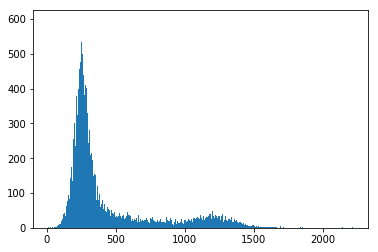

In [16]:
#histogram of the S0 values (b0 image)
x = plt.hist(S0s.ravel(), 500)

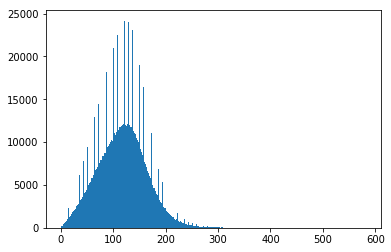

In [17]:
# Histogram of the S_k values
x = plt.hist(data[:, :, :, ~gtab.b0s_mask].ravel(), 500)

The S0 values look nicely bimodal. The S_k values look gaussian with wierd spikes. Are these from eddy currents or head motion?

# Single Compartment model

In [18]:
import dipy.reconst.dti as dti
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(data)

## Fractional Anisotropy

In [19]:
FA = dti.fractional_anisotropy(tenfit.evals)

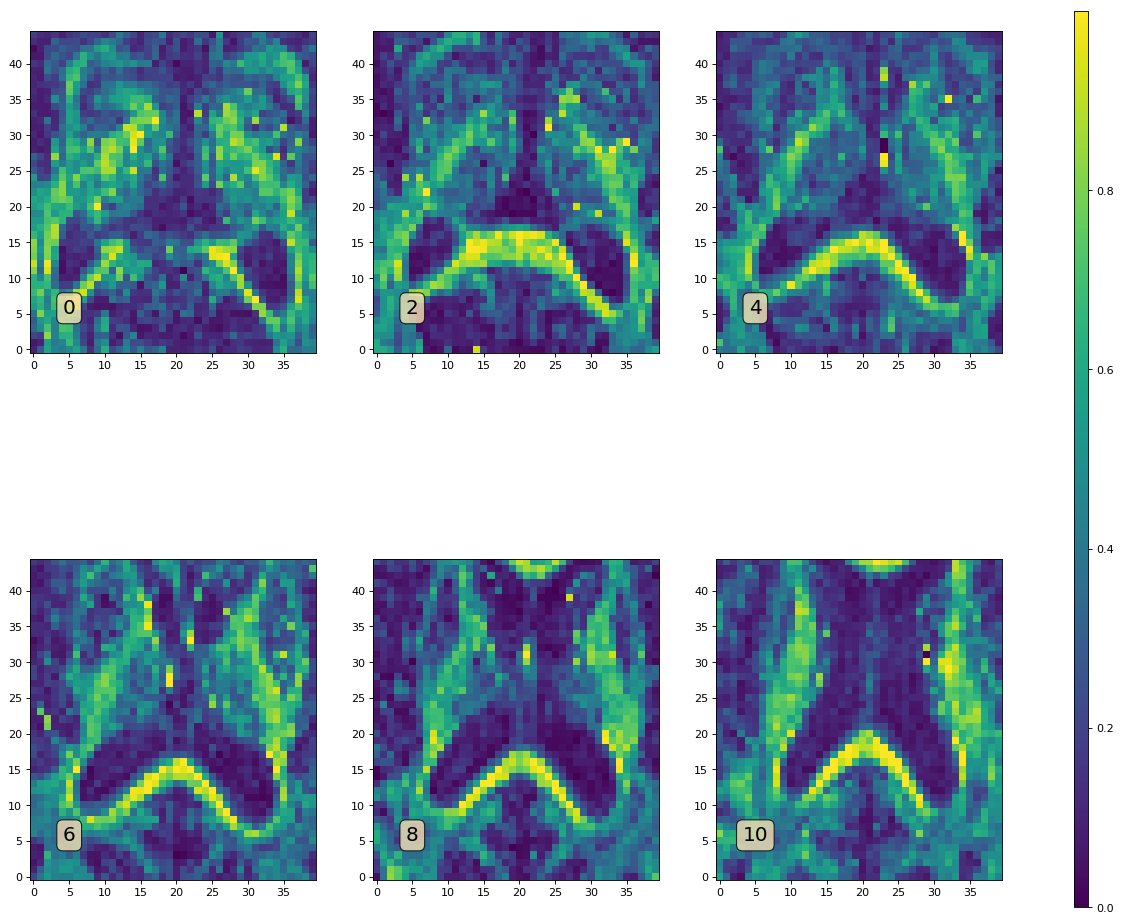

In [20]:
# Plot the FA for a few z-indices
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
im = None
for i, idx in enumerate(range(0, 12, 2)):
    plt.subplot(2, 3, i+1)
    plt.text(5, 5, str(idx), fontsize=18, ha="center", color="black",
            bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    im = plt.imshow(FA[:,:, idx].transpose(), origin="lower")

fig = plt.gcf()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)


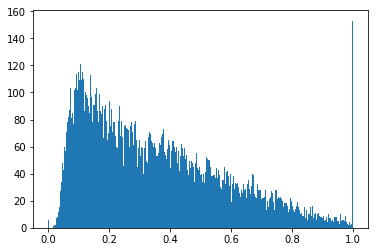

In [21]:
x = plt.hist(FA.ravel(), bins=500)

# Mean Diffusivity

In [22]:
MD1 = dti.mean_diffusivity(tenfit.evals)

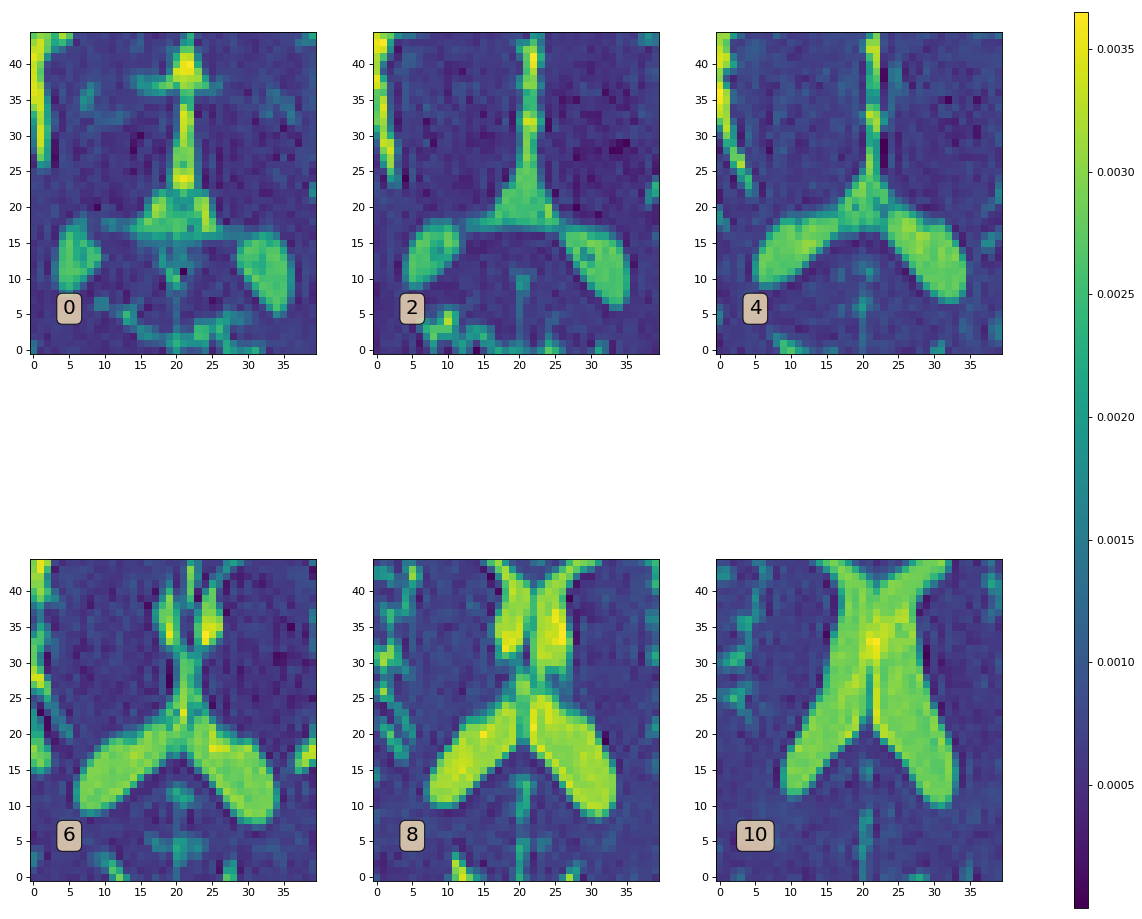

In [23]:
# Plot the MD for a few z-indices
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
im = None
for i, idx in enumerate(range(0, 12, 2)):
    plt.subplot(2, 3, i+1)
    plt.text(5, 5, str(idx), fontsize=18, ha="center", color="black",
            bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    im = plt.imshow(MD1[:,:, idx].transpose(), origin="lower")

fig = plt.gcf()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


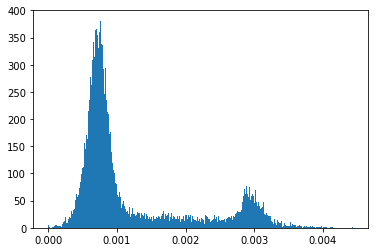

In [24]:
x = plt.hist(MD1.ravel(), bins=500)

# Bi-tensor Model (Free Water)

In [25]:
data_bi = data.astype(np.float_, copy=True)
S0s_bi = data_bi[:,:,:,gtab.b0s_mask]

In [26]:
print("Min = %f, Max=%f" % (data_bi.min(), data_bi.max()))

Min = 0.000000, Max=2216.000000


In [27]:
data_bi[data_bi <= 0] = dipy.reconst.dti.MIN_POSITIVE_SIGNAL

NameError: name 'dipy' is not defined

In [ ]:
print("Min = %f, Max=%f" % (data_bi.min(), data_bi.max()))

## Initialization of Free Water Map

In [ ]:
# look at the distribution of voxels in the b0 image that are near 3*1e-3 mm^2/s
mask = np.abs(MD1 - 3 * 1e-3) < 0.2 * 1e-3
print("Fraction of Data Selected = %.2f" % (sum(mask.ravel()) / mask.size))
x = plt.hist(S0s_bi[mask].ravel(), bins=500)

In [ ]:
#Lets set the value of Swater to be 1500 as that is close 
# to the end of the distribution in percentile terms
Swater = 1500 

In [ ]:
# look at the distribution of voxels that are near 0.8*1e-3 mm^2/s
mask = np.abs(MD1 - 0.8 * 1e-3) < 0.2 * 1e-3
print("Fraction of Data Selected = %.2f" % (sum(mask.ravel()) / mask.size))
x = plt.hist(S0s_bi[mask].ravel(), bins=500)

In [ ]:
# Lets set the value of Stissue to be 200 as that is close
# to the start of the distribution above in percentile terms
Stissue = 200

In [ ]:
#Initial free water map
fmin, fmax = 0.01, 0.99
f = 1 - (np.log(S0s_bi / Stissue) / np.log(Swater / Stissue))
f[f < fmin] = (fmin + fmax)/2
f[f > fmax] = (fmin + fmax)/2

# This is our starting value of f
print("f.shape = %s" % str(f.shape))

In [ ]:
att_f = data_bi.copy() # attenuations
S0s_att_f = att_f[:,:,:,gtab.b0s_mask]
att_f = att_f / S0s_att_f

att_f[att_f > 1] = 1.
Ahat = att_f.copy()

att_f = Ahat - (1 - f) * np.exp(-1000 * 3 * 1e-3)

In [ ]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(att_f)
FA = dti.fractional_anisotropy(tenfit.evals)

In [ ]:
# This is our starting value of D
tenfit.quadratic_form.shape